In [19]:
%pip install tensorflow
%pip install pandas
%pip install scikit-learn
%pip install imbalanced-learn
%pip install shap
%pip install matplotlib





Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from imblearn.over_sampling import SMOTE
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter






## Load and split data

In [21]:
train_dir = "train_cleaned.csv"
train_data = pd.read_csv(train_dir)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Columns: 107 entries, Available Extra Rooms in Hospital to City_Code_Patient_9
dtypes: bool(99), float64(7), int64(1)
memory usage: 49.5 MB


In [22]:
X = train_data.drop(columns=['Stay'])
X = X.astype('float32')
y = train_data['Stay']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)      

In [23]:
# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [24]:
# Get the number of input features and classes
num_features = X_train_balanced.shape[1]
num_classes = len(np.unique(y_train_balanced))

In [25]:
print(X_train.dtypes)


Available Extra Rooms in Hospital    float32
Bed Grade                            float32
Type of Admission                    float32
Severity of Illness                  float32
Visitors with Patient                float32
                                      ...   
City_Code_Patient_5                  float32
City_Code_Patient_6                  float32
City_Code_Patient_7                  float32
City_Code_Patient_8                  float32
City_Code_Patient_9                  float32
Length: 106, dtype: object


## Neural Network

In [26]:
def build_model(input_dim, num_classes):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [27]:
# Original data (no SMOTE)
model_orig = build_model(input_dim=X_train.shape[1], num_classes=num_classes)

print("Training model WITHOUT SMOTE...")
history_orig = model_orig.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Evaluate
loss_orig, acc_orig = model_orig.evaluate(X_test, y_test)
print(f"Accuracy WITHOUT SMOTE: {acc_orig:.4f}")


Training model WITHOUT SMOTE...
Epoch 1/10


\\labdrive.tntech.edu\labdrive\rggrimaud42\Documents\GitHub\4260\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6369/6369 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.2982 - loss: 1.9272 - val_accuracy: 0.3970 - val_loss: 1.5856
Epoch 2/10
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.3900 - loss: 1.6199 - val_accuracy: 0.4068 - val_loss: 1.5626
Epoch 3/10
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.3944 - loss: 1.6055 - val_accuracy: 0.4101 - val_loss: 1.5548
Epoch 4/10
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.3987 - loss: 1.5890 - val_accuracy: 0.4156 - val_loss: 1.5434
Epoch 5/10
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4005 - loss: 1.5836 - val_accuracy: 0.4139 - val_loss: 1.5421
Epoch 6/10
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4029 - loss: 1.5764 - val_accuracy: 0.4148 - val_loss: 1.5363
Epoch 7/10
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4038 - loss: 1.5791 - val_accuracy: 0.4149 - val_loss: 1.5375
Epoch 8/10
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4069 - loss: 1.5696 - val

In [28]:
# SMOTE-augmented data
model_smote = build_model(input_dim=X_train_balanced.shape[1], num_classes=num_classes)

print("Training model WITH SMOTE...")
history_smote = model_smote.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Evaluate
loss_smote, acc_smote = model_smote.evaluate(X_test, y_test)
print(f"Accuracy WITH SMOTE: {acc_smote:.4f}")


Training model WITH SMOTE...


\\labdrive.tntech.edu\labdrive\rggrimaud42\Documents\GitHub\4260\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
19249/19249 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.2536 - loss: 1.9822 - val_accuracy: 0.1473 - val_loss: 3.6419
Epoch 2/10
19249/19249 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.3175 - loss: 1.7921 - val_accuracy: 0.1657 - val_loss: 3.5531
Epoch 3/10
19249/19249 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.3320 - loss: 1.7644 - val_accuracy: 0.1665 - val_loss: 3.5623
Epoch 4/10
19249/19249 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.3389 - loss: 1.7503 - val_accuracy: 0.1788 - val_loss: 3.4682
Epoch 5/10
19249/19249 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.3431 - loss: 1.7377 - val_accuracy: 0.1854 - val_loss: 3.4783
Epoch 6/10
19249/19249 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.3490 - loss: 1.7261 - val_accuracy: 0.1868 - val_loss: 3.4392
Epoch 7/10
19249/19249 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.3520 - loss: 1.7224 - val_accuracy: 0.1680 - val_loss: 3.6181
Epoch 8/10
19249/19249 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 

1991/1991 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step

Confusion Matrix for clean Neural Network:
[[  819  2179  1658    33     0    32     0     0     0     0     0]
 [  525  7404  6227   858     0   614     0     0     0     0     0]
 [  393  4709 11566   377     0   430     0     0     0     0    23]
 [  226  1595  4697  1968     0  2518     0     0     0     0    28]
 [   89   329  1575   102     0   231     0     0     0     0    23]
 [  110   400  1095  1111     0  4137     0     1     0     0   150]
 [   19    59   304    47     0   102     0     0     0     0    18]
 [   29    69   230   195     0  1358     0     0     0     0   170]
 [    9    29    49    91     0   609     0     0     0     0   180]
 [    8    15    64    51     0   345     0     1     0     0    69]
 [   28    28    73    57     0   547     0     1     0     0   602]]


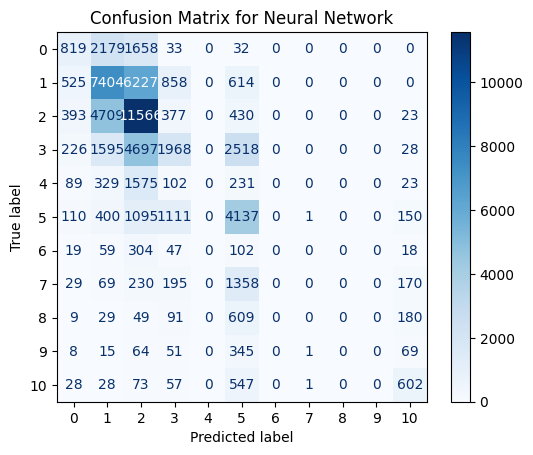

In [34]:
#Confusion matrix for model without SMOTE
y_pred_probs = model_orig.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert softmax outputs to class predictions

if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Generate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

print("\nConfusion Matrix for clean Neural Network:")
print(cm)

# Can use class labels from the data if available
class_names = [str(i) for i in np.unique(y_test_labels)]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Neural Network")
plt.show()



1991/1991 ━━━━━━━━━━━━━━━━━━━━ 2s 839us/step

Confusion Matrix for Neural Network:
[[2924  656  435   15  436   25  211   19    0    0    0]
 [4833 4260 2516  351 1687  735  960  234   52    0    0]
 [3777 2931 4682  160 3210  278 2172  154  133    0    1]
 [1497  891 1401  697 1585 2583 1188  920  269    0    1]
 [ 426  182  405   40  577  143  425  102   35    0   14]
 [ 461  198  357  327  300 2513  342 1726  767    0   13]
 [  79   22   88   12  111   56   92   57   28    0    4]
 [ 100   33   60   45   71  605   89  818  198    0   32]
 [  41    9   16   16    9  146   20  158  547    0    5]
 [  22    9   22    8   17  137   26  227   42    0   43]
 [  57   13   18   19   22  123   35  407  414    0  228]]


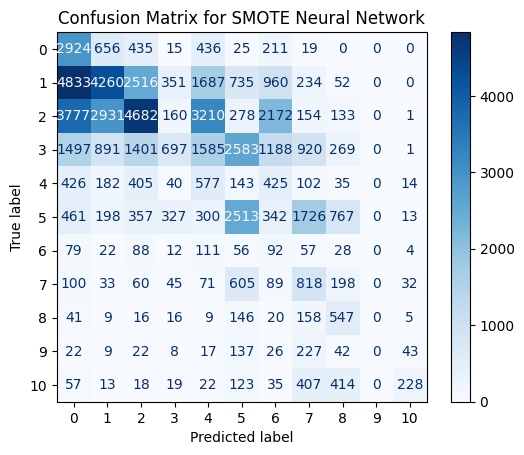

In [32]:
#Confusion matrix for model with SMOTE
y_pred_probs = model_smote.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert softmax outputs to class predictions

if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Generate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

print("\nConfusion Matrix for Neural Network:")
print(cm)

# Can use class labels from the data if available
class_names = [str(i) for i in np.unique(y_test_labels)]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SMOTE Neural Network")
plt.show()


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
95/9

PermutationExplainer explainer:  12%|█▏        | 12/100 [00:00<?, ?it/s]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  14%|█▍        | 14/100 [00:11<00:39,  2.20it/s]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  15%|█▌        | 15/100 [00:12<00:50,  1.67it/s]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  16%|█▌        | 16/100 [00:13<00:57,  1.46it/s]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  17%|█▋        | 17/100 [00:14<01:00,  1.38it/s]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  18%|█▊        | 18/100 [00:15<01:05,  1.25it/s]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  19%|█▉        | 19/100 [00:16<01:08,  1.19it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  20%|██        | 20/100 [00:16<01:06,  1.20it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 21/100 [00:17<01:04,  1.23it/s]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  22%|██▏       | 22/100 [00:18<01:04,  1.22it/s]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  23%|██▎       | 23/100 [00:19<01:03,  1.22it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step


PermutationExplainer explainer:  24%|██▍       | 24/100 [00:20<00:59,  1.27it/s]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  25%|██▌       | 25/100 [00:20<00:59,  1.26it/s]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  26%|██▌       | 26/100 [00:21<00:57,  1.28it/s]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  27%|██▋       | 27/100 [00:22<01:00,  1.21it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 28/100 [00:23<00:57,  1.25it/s]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step


PermutationExplainer explainer:  29%|██▉       | 29/100 [00:24<00:55,  1.29it/s]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  30%|███       | 30/100 [00:24<00:54,  1.28it/s]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  31%|███       | 31/100 [00:25<00:54,  1.27it/s]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  32%|███▏      | 32/100 [00:26<00:53,  1.27it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  33%|███▎      | 33/100 [00:27<00:53,  1.25it/s]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  34%|███▍      | 34/100 [00:28<00:53,  1.23it/s]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


PermutationExplainer explainer:  35%|███▌      | 35/100 [00:28<00:50,  1.28it/s]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


PermutationExplainer explainer:  36%|███▌      | 36/100 [00:29<00:51,  1.25it/s]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  37%|███▋      | 37/100 [00:30<00:50,  1.25it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  38%|███▊      | 38/100 [00:31<00:48,  1.28it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  39%|███▉      | 39/100 [00:31<00:47,  1.28it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  40%|████      | 40/100 [00:32<00:45,  1.32it/s]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


PermutationExplainer explainer:  41%|████      | 41/100 [00:33<00:45,  1.30it/s]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step


PermutationExplainer explainer:  42%|████▏     | 42/100 [00:34<00:42,  1.36it/s]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


PermutationExplainer explainer:  43%|████▎     | 43/100 [00:34<00:41,  1.38it/s]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  44%|████▍     | 44/100 [00:35<00:40,  1.40it/s]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  45%|████▌     | 45/100 [00:36<00:40,  1.35it/s]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


PermutationExplainer explainer:  46%|████▌     | 46/100 [00:36<00:39,  1.38it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  47%|████▋     | 47/100 [00:37<00:39,  1.35it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  48%|████▊     | 48/100 [00:38<00:37,  1.39it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


PermutationExplainer explainer:  49%|████▉     | 49/100 [00:39<00:35,  1.44it/s]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


PermutationExplainer explainer:  50%|█████     | 50/100 [00:39<00:34,  1.43it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  51%|█████     | 51/100 [00:40<00:34,  1.43it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step


PermutationExplainer explainer:  52%|█████▏    | 52/100 [00:41<00:33,  1.44it/s]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


PermutationExplainer explainer:  53%|█████▎    | 53/100 [00:41<00:32,  1.45it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  54%|█████▍    | 54/100 [00:42<00:32,  1.43it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


PermutationExplainer explainer:  55%|█████▌    | 55/100 [00:43<00:30,  1.47it/s]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step


PermutationExplainer explainer:  56%|█████▌    | 56/100 [00:43<00:30,  1.44it/s]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


PermutationExplainer explainer:  57%|█████▋    | 57/100 [00:44<00:30,  1.43it/s]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step


PermutationExplainer explainer:  58%|█████▊    | 58/100 [00:45<00:30,  1.38it/s]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


PermutationExplainer explainer:  59%|█████▉    | 59/100 [00:46<00:28,  1.41it/s]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


PermutationExplainer explainer:  60%|██████    | 60/100 [00:46<00:27,  1.43it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step


PermutationExplainer explainer:  61%|██████    | 61/100 [00:47<00:26,  1.45it/s]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step


PermutationExplainer explainer:  62%|██████▏   | 62/100 [00:48<00:26,  1.45it/s]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  63%|██████▎   | 63/100 [00:48<00:25,  1.45it/s]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  64%|██████▍   | 64/100 [00:49<00:25,  1.43it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  65%|██████▌   | 65/100 [00:50<00:24,  1.43it/s]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


PermutationExplainer explainer:  66%|██████▌   | 66/100 [00:50<00:24,  1.39it/s]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


PermutationExplainer explainer:  67%|██████▋   | 67/100 [00:51<00:23,  1.40it/s]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step


PermutationExplainer explainer:  68%|██████▊   | 68/100 [00:52<00:22,  1.44it/s]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


PermutationExplainer explainer:  69%|██████▉   | 69/100 [00:53<00:21,  1.45it/s]

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


PermutationExplainer explainer:  70%|███████   | 70/100 [00:53<00:21,  1.42it/s]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step


PermutationExplainer explainer:  71%|███████   | 71/100 [00:54<00:20,  1.39it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


PermutationExplainer explainer:  72%|███████▏  | 72/100 [00:55<00:20,  1.39it/s]

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step


PermutationExplainer explainer:  73%|███████▎  | 73/100 [00:55<00:19,  1.39it/s]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step


PermutationExplainer explainer:  74%|███████▍  | 74/100 [00:56<00:18,  1.42it/s]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  75%|███████▌  | 75/100 [00:57<00:18,  1.37it/s]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


PermutationExplainer explainer:  76%|███████▌  | 76/100 [00:58<00:17,  1.36it/s]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


PermutationExplainer explainer:  77%|███████▋  | 77/100 [00:58<00:16,  1.38it/s]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


PermutationExplainer explainer:  78%|███████▊  | 78/100 [00:59<00:15,  1.41it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


PermutationExplainer explainer:  79%|███████▉  | 79/100 [01:00<00:15,  1.37it/s]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step


PermutationExplainer explainer:  80%|████████  | 80/100 [01:00<00:14,  1.38it/s]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


PermutationExplainer explainer:  81%|████████  | 81/100 [01:01<00:13,  1.42it/s]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


PermutationExplainer explainer:  82%|████████▏ | 82/100 [01:02<00:12,  1.44it/s]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


PermutationExplainer explainer:  83%|████████▎ | 83/100 [01:03<00:11,  1.43it/s]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


PermutationExplainer explainer:  84%|████████▍ | 84/100 [01:03<00:11,  1.43it/s]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


PermutationExplainer explainer:  85%|████████▌ | 85/100 [01:04<00:10,  1.43it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


PermutationExplainer explainer:  86%|████████▌ | 86/100 [01:05<00:09,  1.40it/s]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step


PermutationExplainer explainer:  87%|████████▋ | 87/100 [01:05<00:09,  1.40it/s]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step


PermutationExplainer explainer:  88%|████████▊ | 88/100 [01:06<00:08,  1.44it/s]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


PermutationExplainer explainer:  89%|████████▉ | 89/100 [01:07<00:07,  1.44it/s]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step


PermutationExplainer explainer:  90%|█████████ | 90/100 [01:07<00:06,  1.48it/s]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  91%|█████████ | 91/100 [01:08<00:06,  1.48it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step


PermutationExplainer explainer:  92%|█████████▏| 92/100 [01:09<00:05,  1.48it/s]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step


PermutationExplainer explainer:  93%|█████████▎| 93/100 [01:09<00:04,  1.45it/s]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  94%|█████████▍| 94/100 [01:10<00:04,  1.43it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


PermutationExplainer explainer:  95%|█████████▌| 95/100 [01:11<00:03,  1.41it/s]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


PermutationExplainer explainer:  96%|█████████▌| 96/100 [01:12<00:02,  1.40it/s]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step


PermutationExplainer explainer:  97%|█████████▋| 97/100 [01:12<00:02,  1.42it/s]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


PermutationExplainer explainer:  98%|█████████▊| 98/100 [01:13<00:01,  1.42it/s]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


PermutationExplainer explainer:  99%|█████████▉| 99/100 [01:14<00:00,  1.41it/s]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


PermutationExplainer explainer: 100%|██████████| 100/100 [01:14<00:00,  1.38it/s]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


PermutationExplainer explainer: 101it [01:15,  1.18it/s]                         

SHAP values shape (SMOTE): (100, 106, 11)

🔹 Class 0 SHAP Summary with SMOTE


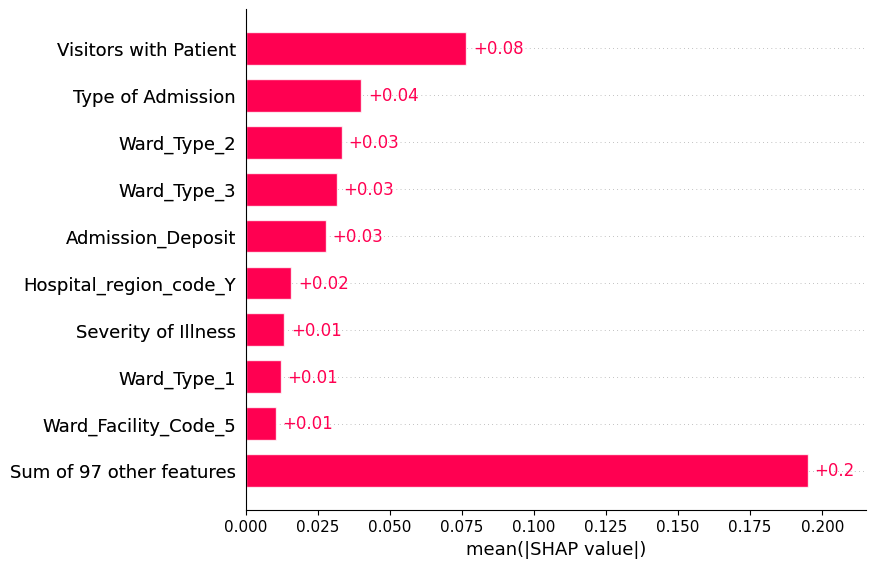


🔹 Class 1 SHAP Summary with SMOTE


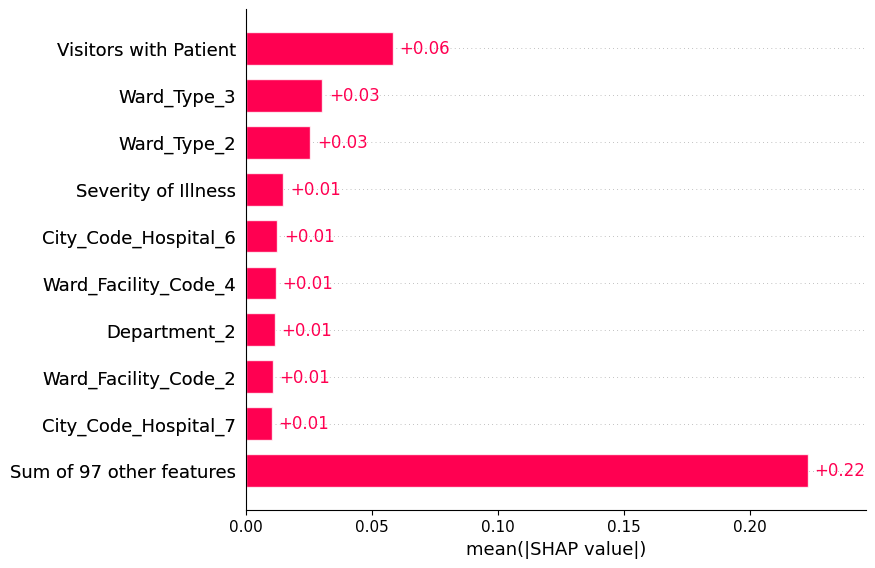


🔹 Class 2 SHAP Summary with SMOTE


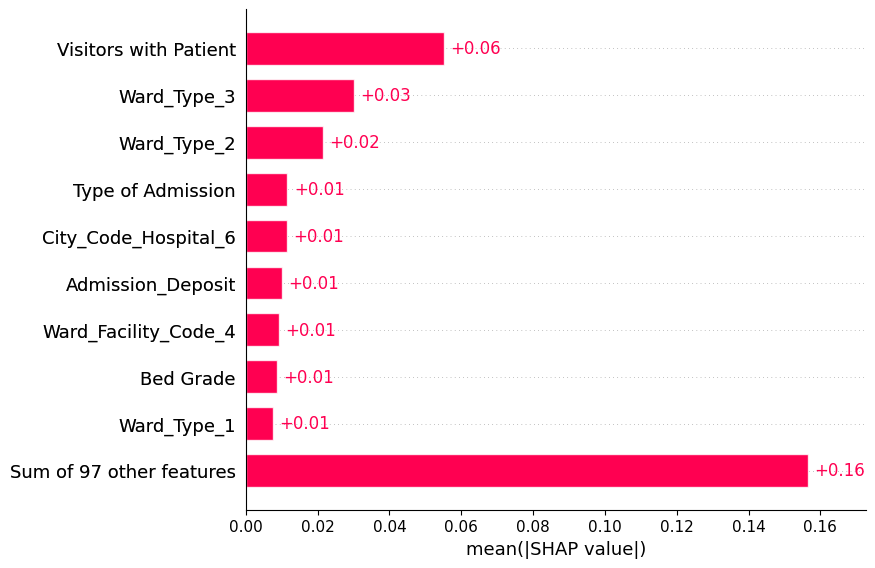


🔹 Class 3 SHAP Summary with SMOTE


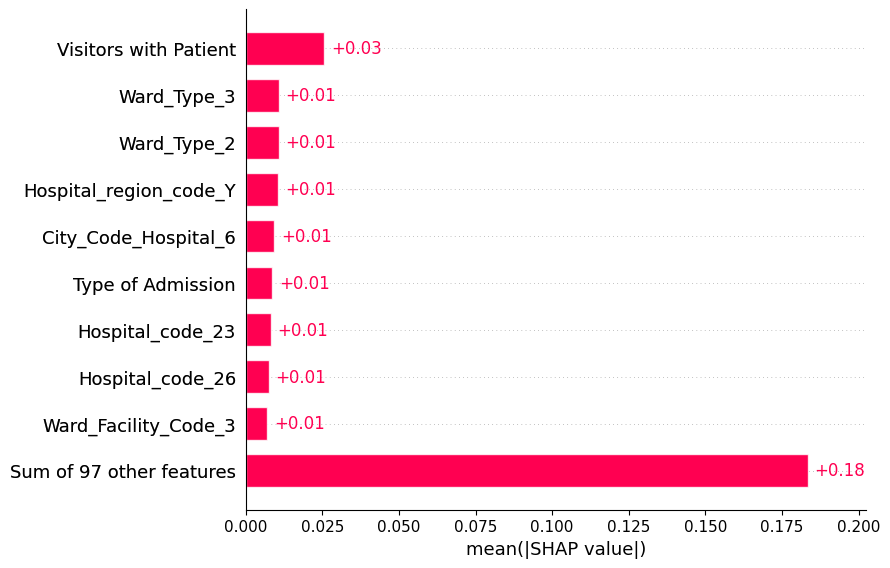


🔹 Class 4 SHAP Summary with SMOTE


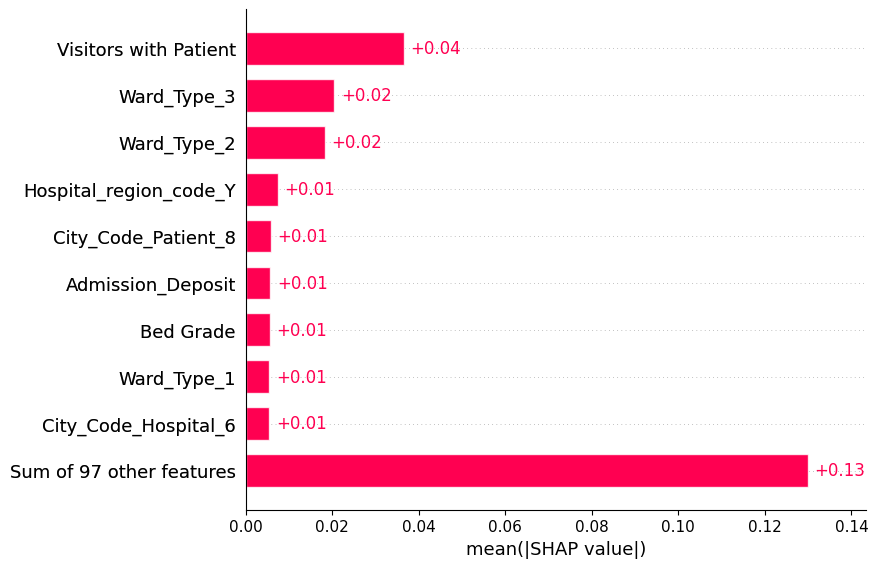


🔹 Class 5 SHAP Summary with SMOTE


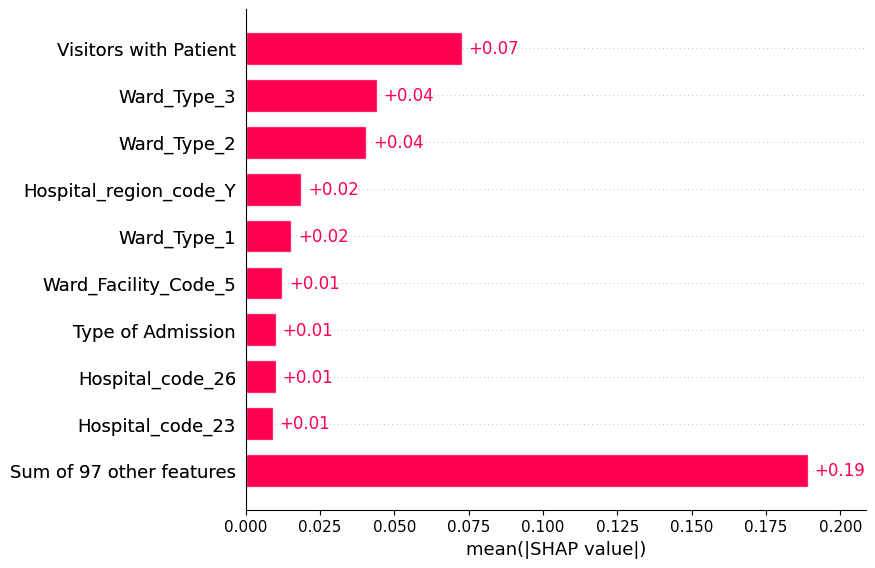


🔹 Class 6 SHAP Summary with SMOTE


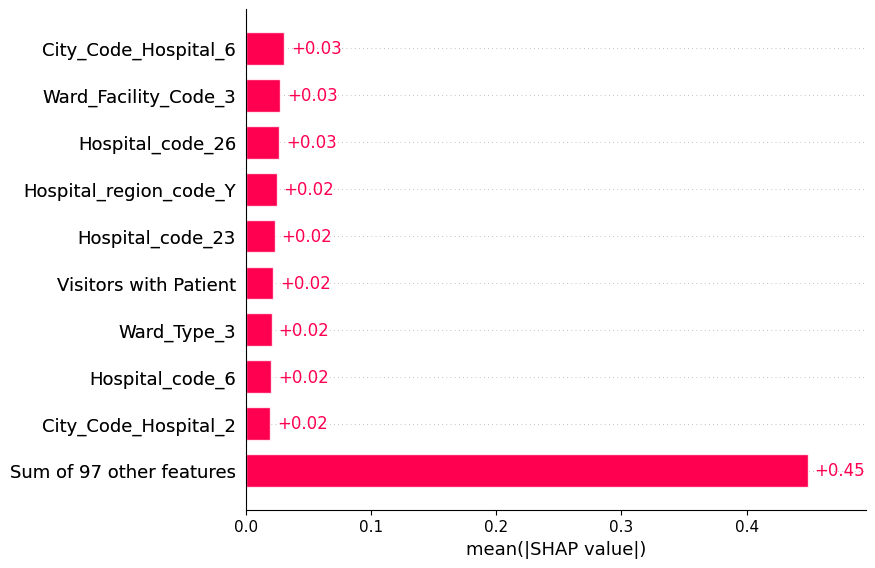


🔹 Class 7 SHAP Summary with SMOTE


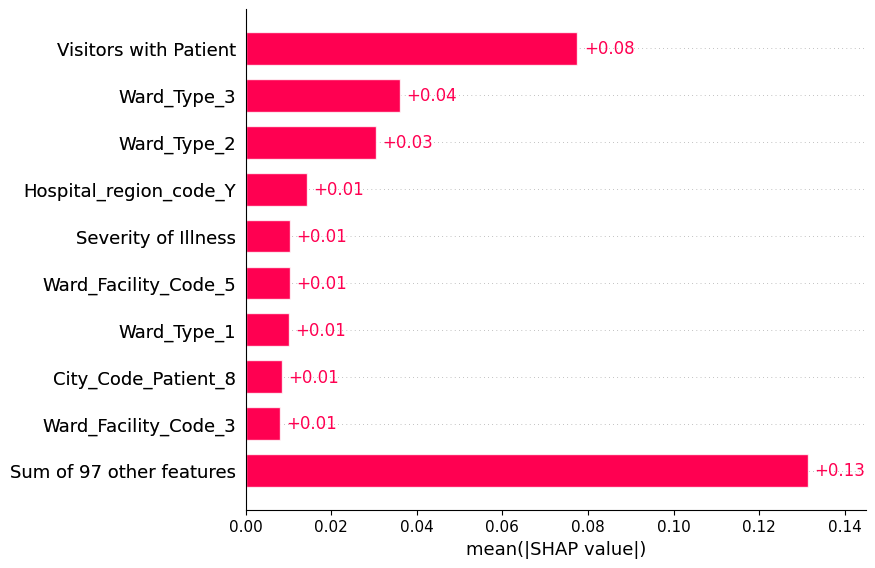


🔹 Class 8 SHAP Summary with SMOTE


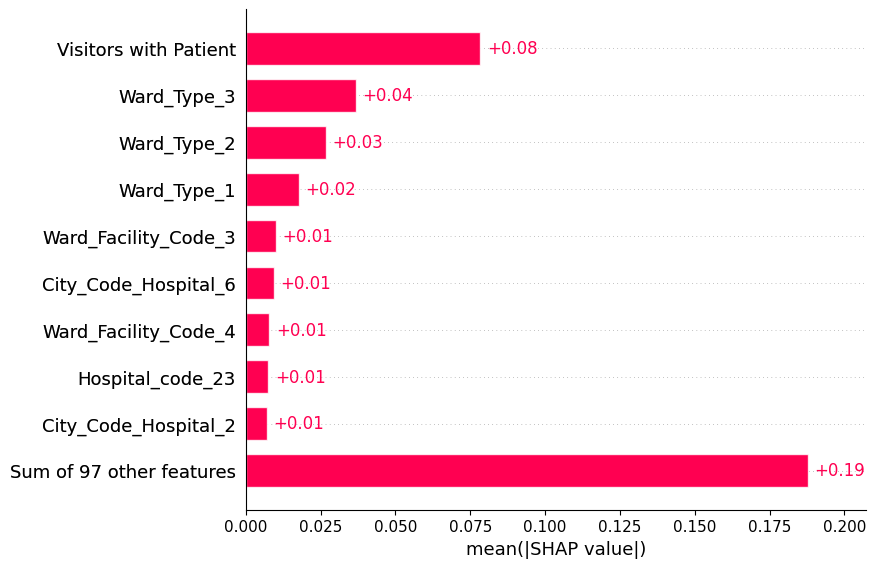


🔹 Class 9 SHAP Summary with SMOTE


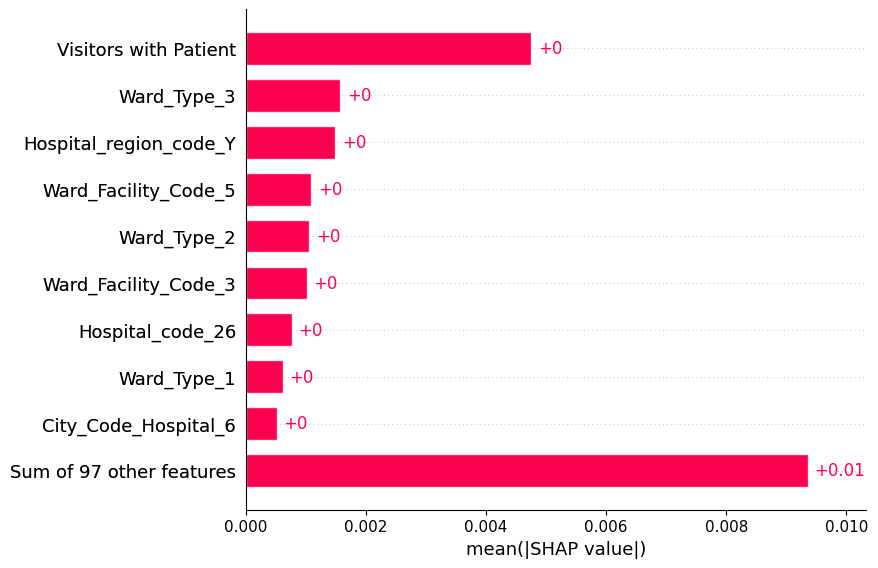


🔹 Class 10 SHAP Summary with SMOTE


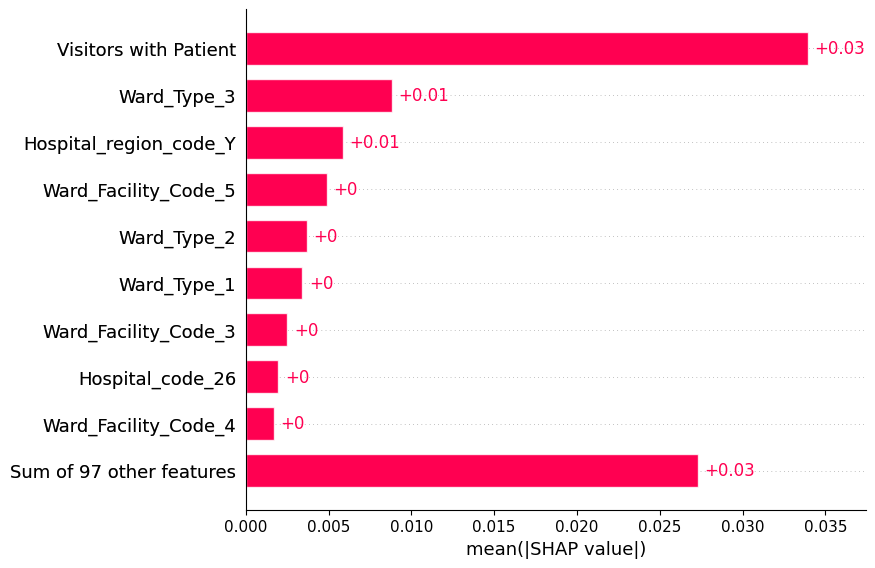

In [ ]:
# Make sure X_test has feature names for SHAP
feature_names = list(X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=feature_names)
sample_X = X_test_df.sample(100, random_state=42).reset_index(drop=True)

# SHAP Explainer for SMOTE model
explainer_smote = shap.Explainer(model_smote.predict, X_train_balanced)
shap_values_smote = explainer_smote(sample_X)

print("SHAP values shape (SMOTE):", shap_values_smote.shape)

# Bar plots for each class
for i in range(shap_values_smote.shape[2]):
    print(f"\n🔹 Class {i} SHAP Summary with SMOTE")
    shap.plots.bar(shap_values_smote[:, :, i])


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━

PermutationExplainer explainer:  14%|█▍        | 14/100 [00:00<?, ?it/s]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  16%|█▌        | 16/100 [00:11<00:33,  2.48it/s]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


PermutationExplainer explainer:  17%|█▋        | 17/100 [00:11<00:44,  1.88it/s]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


PermutationExplainer explainer:  18%|█▊        | 18/100 [00:12<00:50,  1.62it/s]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step


PermutationExplainer explainer:  19%|█▉        | 19/100 [00:13<00:51,  1.56it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


PermutationExplainer explainer:  20%|██        | 20/100 [00:14<00:52,  1.52it/s]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  21%|██        | 21/100 [00:14<00:51,  1.53it/s]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  22%|██▏       | 22/100 [00:15<00:51,  1.53it/s]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


PermutationExplainer explainer:  23%|██▎       | 23/100 [00:16<00:50,  1.51it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  24%|██▍       | 24/100 [00:16<00:49,  1.53it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


PermutationExplainer explainer:  25%|██▌       | 25/100 [00:17<00:49,  1.52it/s]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


PermutationExplainer explainer:  26%|██▌       | 26/100 [00:18<00:47,  1.54it/s]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step


PermutationExplainer explainer:  27%|██▋       | 27/100 [00:18<00:46,  1.56it/s]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  28%|██▊       | 28/100 [00:19<00:47,  1.50it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


PermutationExplainer explainer:  29%|██▉       | 29/100 [00:20<00:48,  1.47it/s]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  30%|███       | 30/100 [00:20<00:49,  1.42it/s]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  31%|███       | 31/100 [00:21<00:52,  1.32it/s]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  32%|███▏      | 32/100 [00:22<00:51,  1.33it/s]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step


PermutationExplainer explainer:  33%|███▎      | 33/100 [00:23<00:47,  1.42it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  34%|███▍      | 34/100 [00:23<00:45,  1.46it/s]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step


PermutationExplainer explainer:  35%|███▌      | 35/100 [00:24<00:43,  1.49it/s]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer:  36%|███▌      | 36/100 [00:24<00:42,  1.51it/s]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


PermutationExplainer explainer:  37%|███▋      | 37/100 [00:25<00:40,  1.56it/s]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  38%|███▊      | 38/100 [00:26<00:42,  1.46it/s]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  39%|███▉      | 39/100 [00:27<00:45,  1.35it/s]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step


PermutationExplainer explainer:  40%|████      | 40/100 [00:27<00:43,  1.39it/s]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  41%|████      | 41/100 [00:28<00:42,  1.39it/s]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  42%|████▏     | 42/100 [00:29<00:40,  1.41it/s]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  43%|████▎     | 43/100 [00:29<00:39,  1.43it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


PermutationExplainer explainer:  44%|████▍     | 44/100 [00:30<00:38,  1.47it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step


PermutationExplainer explainer:  45%|████▌     | 45/100 [00:31<00:36,  1.49it/s]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step


PermutationExplainer explainer:  46%|████▌     | 46/100 [00:31<00:36,  1.49it/s]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


PermutationExplainer explainer:  47%|████▋     | 47/100 [00:32<00:35,  1.47it/s]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step


PermutationExplainer explainer:  48%|████▊     | 48/100 [00:33<00:34,  1.49it/s]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  49%|████▉     | 49/100 [00:33<00:35,  1.46it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step


PermutationExplainer explainer:  50%|█████     | 50/100 [00:34<00:33,  1.50it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


PermutationExplainer explainer:  51%|█████     | 51/100 [00:35<00:32,  1.53it/s]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step


PermutationExplainer explainer:  52%|█████▏    | 52/100 [00:35<00:30,  1.56it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


PermutationExplainer explainer:  53%|█████▎    | 53/100 [00:36<00:29,  1.58it/s]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step


PermutationExplainer explainer:  54%|█████▍    | 54/100 [00:37<00:30,  1.53it/s]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step


PermutationExplainer explainer:  55%|█████▌    | 55/100 [00:37<00:29,  1.55it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


PermutationExplainer explainer:  56%|█████▌    | 56/100 [00:38<00:28,  1.57it/s]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


PermutationExplainer explainer:  57%|█████▋    | 57/100 [00:39<00:27,  1.57it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


PermutationExplainer explainer:  58%|█████▊    | 58/100 [00:39<00:26,  1.58it/s]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


PermutationExplainer explainer:  59%|█████▉    | 59/100 [00:40<00:25,  1.60it/s]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step


PermutationExplainer explainer:  60%|██████    | 60/100 [00:40<00:25,  1.60it/s]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


PermutationExplainer explainer:  61%|██████    | 61/100 [00:41<00:24,  1.58it/s]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step


PermutationExplainer explainer:  62%|██████▏   | 62/100 [00:42<00:23,  1.60it/s]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


PermutationExplainer explainer:  63%|██████▎   | 63/100 [00:42<00:23,  1.60it/s]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


PermutationExplainer explainer:  64%|██████▍   | 64/100 [00:43<00:22,  1.59it/s]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


PermutationExplainer explainer:  65%|██████▌   | 65/100 [00:44<00:22,  1.56it/s]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


PermutationExplainer explainer:  66%|██████▌   | 66/100 [00:44<00:21,  1.56it/s]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


PermutationExplainer explainer:  67%|██████▋   | 67/100 [00:45<00:21,  1.53it/s]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step


PermutationExplainer explainer:  68%|██████▊   | 68/100 [00:46<00:21,  1.48it/s]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


PermutationExplainer explainer:  69%|██████▉   | 69/100 [00:46<00:20,  1.52it/s]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


PermutationExplainer explainer:  70%|███████   | 70/100 [00:47<00:19,  1.53it/s]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:  71%|███████   | 71/100 [00:48<00:18,  1.54it/s]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


PermutationExplainer explainer:  72%|███████▏  | 72/100 [00:48<00:17,  1.58it/s]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


PermutationExplainer explainer:  73%|███████▎  | 73/100 [00:49<00:17,  1.55it/s]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step


PermutationExplainer explainer:  74%|███████▍  | 74/100 [00:49<00:16,  1.57it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  75%|███████▌  | 75/100 [00:50<00:16,  1.49it/s]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  76%|███████▌  | 76/100 [00:51<00:16,  1.50it/s]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step


PermutationExplainer explainer:  77%|███████▋  | 77/100 [00:52<00:15,  1.44it/s]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  78%|███████▊  | 78/100 [00:52<00:14,  1.51it/s]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step


PermutationExplainer explainer:  79%|███████▉  | 79/100 [00:53<00:14,  1.50it/s]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  80%|████████  | 80/100 [00:54<00:13,  1.43it/s]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


PermutationExplainer explainer:  81%|████████  | 81/100 [00:54<00:12,  1.48it/s]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


PermutationExplainer explainer:  82%|████████▏ | 82/100 [00:55<00:12,  1.45it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


PermutationExplainer explainer:  83%|████████▎ | 83/100 [00:56<00:11,  1.50it/s]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


PermutationExplainer explainer:  84%|████████▍ | 84/100 [00:56<00:10,  1.50it/s]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  85%|████████▌ | 85/100 [00:57<00:09,  1.52it/s]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


PermutationExplainer explainer:  86%|████████▌ | 86/100 [00:58<00:09,  1.54it/s]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


PermutationExplainer explainer:  87%|████████▋ | 87/100 [00:58<00:08,  1.52it/s]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


PermutationExplainer explainer:  88%|████████▊ | 88/100 [00:59<00:07,  1.52it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  89%|████████▉ | 89/100 [01:00<00:07,  1.48it/s]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


PermutationExplainer explainer:  90%|█████████ | 90/100 [01:00<00:06,  1.52it/s]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step


PermutationExplainer explainer:  91%|█████████ | 91/100 [01:01<00:05,  1.54it/s]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step


PermutationExplainer explainer:  92%|█████████▏| 92/100 [01:01<00:05,  1.57it/s]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


PermutationExplainer explainer:  93%|█████████▎| 93/100 [01:02<00:04,  1.58it/s]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step


PermutationExplainer explainer:  94%|█████████▍| 94/100 [01:03<00:03,  1.59it/s]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


PermutationExplainer explainer:  95%|█████████▌| 95/100 [01:03<00:03,  1.57it/s]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


PermutationExplainer explainer:  96%|█████████▌| 96/100 [01:04<00:02,  1.48it/s]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step


PermutationExplainer explainer:  97%|█████████▋| 97/100 [01:05<00:02,  1.50it/s]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


PermutationExplainer explainer:  98%|█████████▊| 98/100 [01:05<00:01,  1.51it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step


PermutationExplainer explainer:  99%|█████████▉| 99/100 [01:06<00:00,  1.50it/s]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step


PermutationExplainer explainer: 100%|██████████| 100/100 [01:07<00:00,  1.51it/s]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer: 101it [01:07,  1.28it/s]                         

SHAP values shape (Original): (100, 106, 11)

🔹 Class 0 SHAP Summary without SMOTE


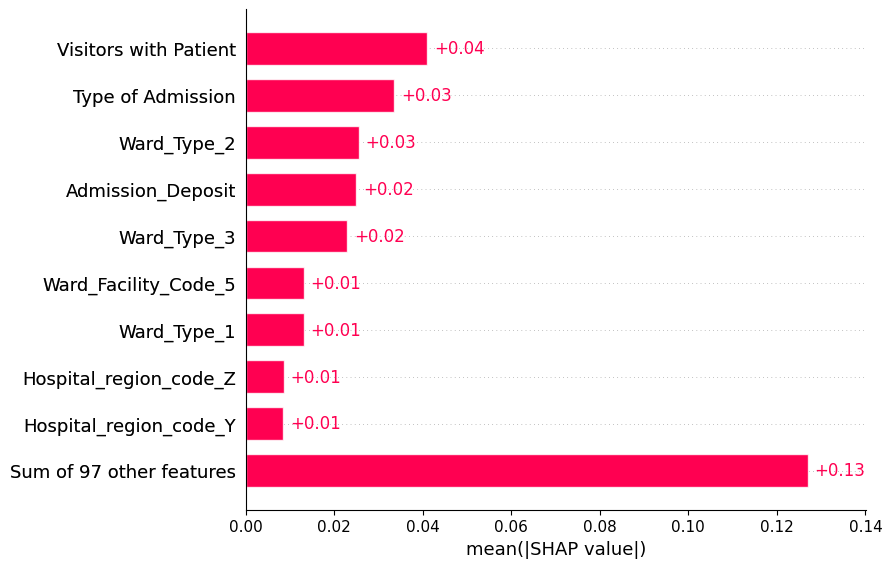


🔹 Class 1 SHAP Summary without SMOTE


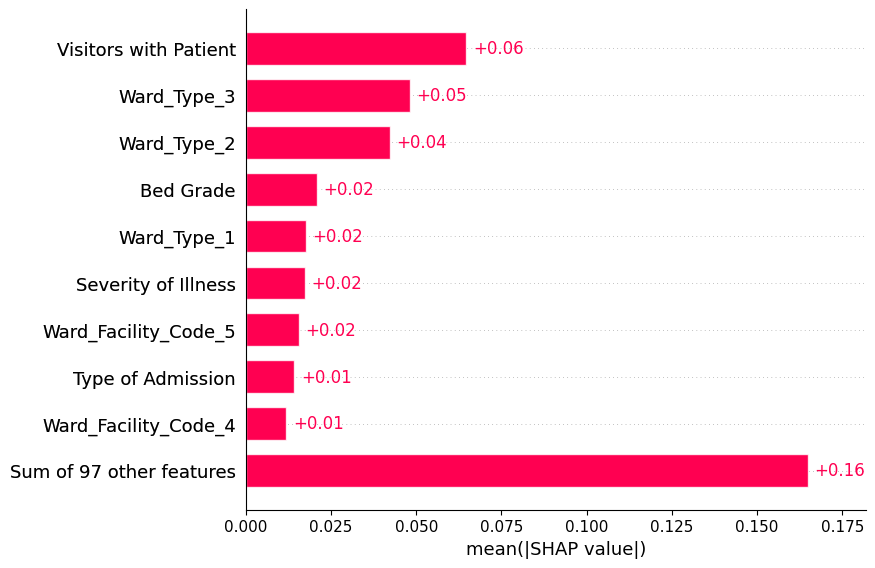


🔹 Class 2 SHAP Summary without SMOTE


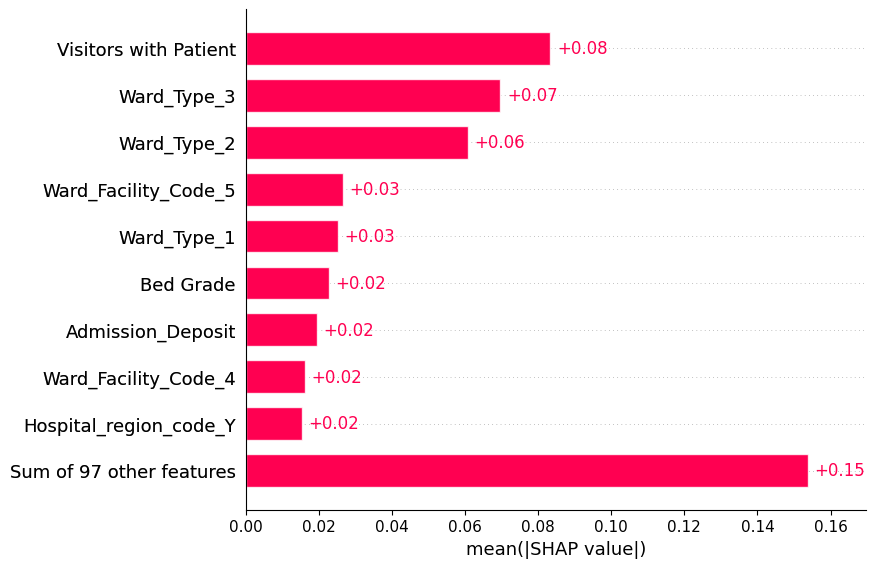


🔹 Class 3 SHAP Summary without SMOTE


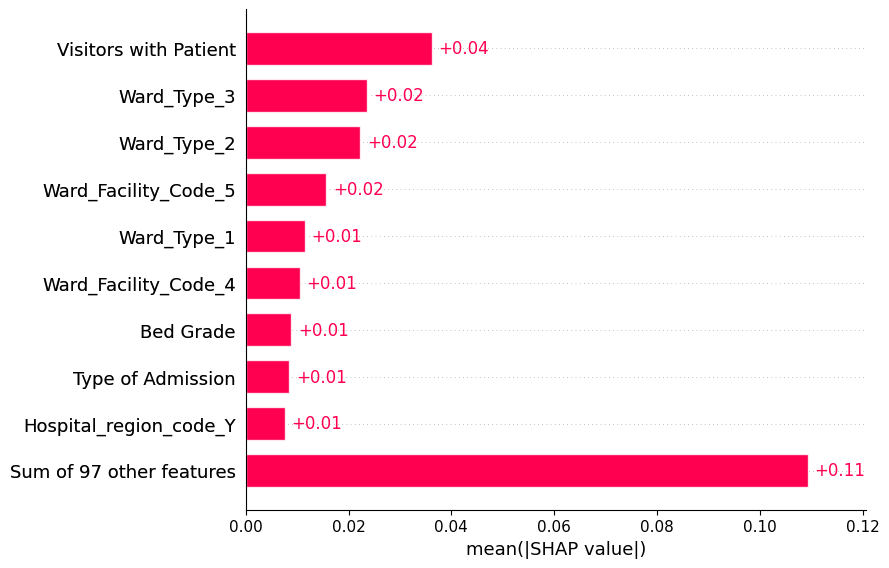


🔹 Class 4 SHAP Summary without SMOTE


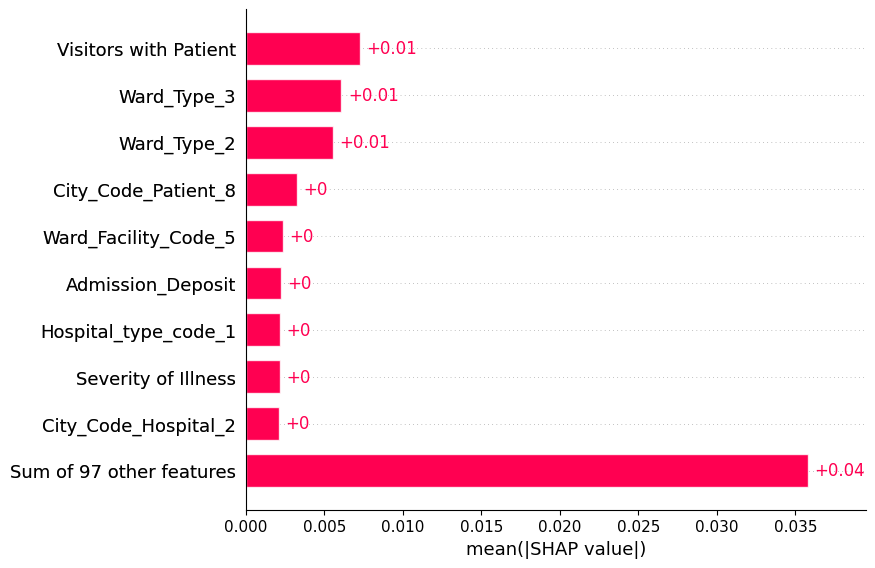


🔹 Class 5 SHAP Summary without SMOTE


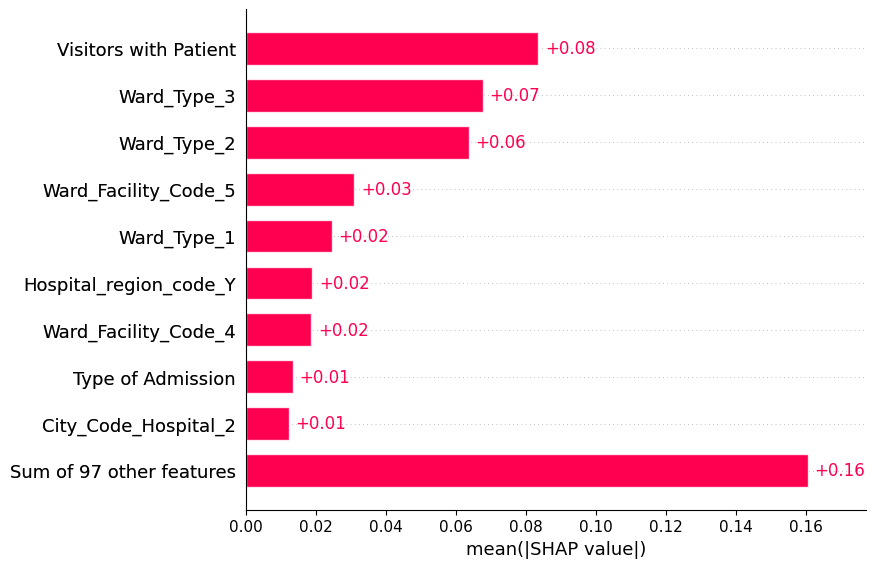


🔹 Class 6 SHAP Summary without SMOTE


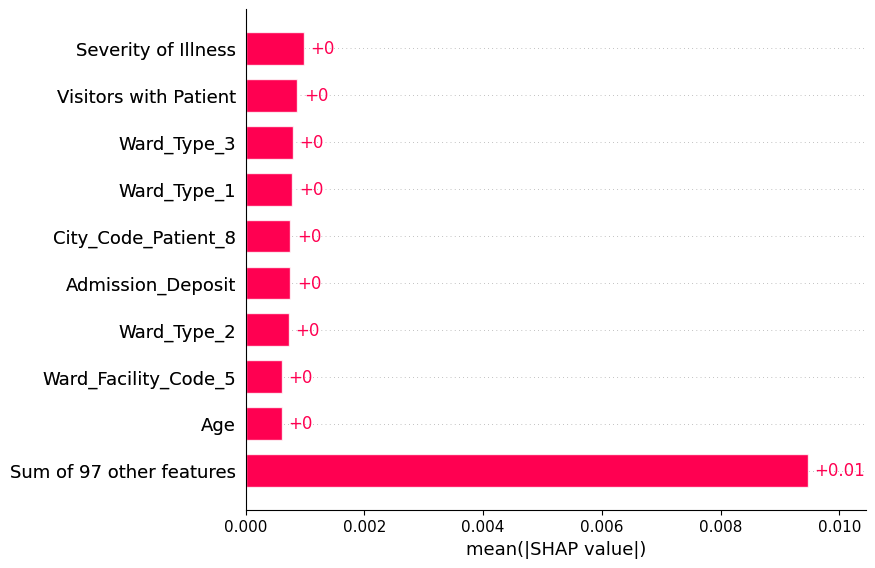


🔹 Class 7 SHAP Summary without SMOTE


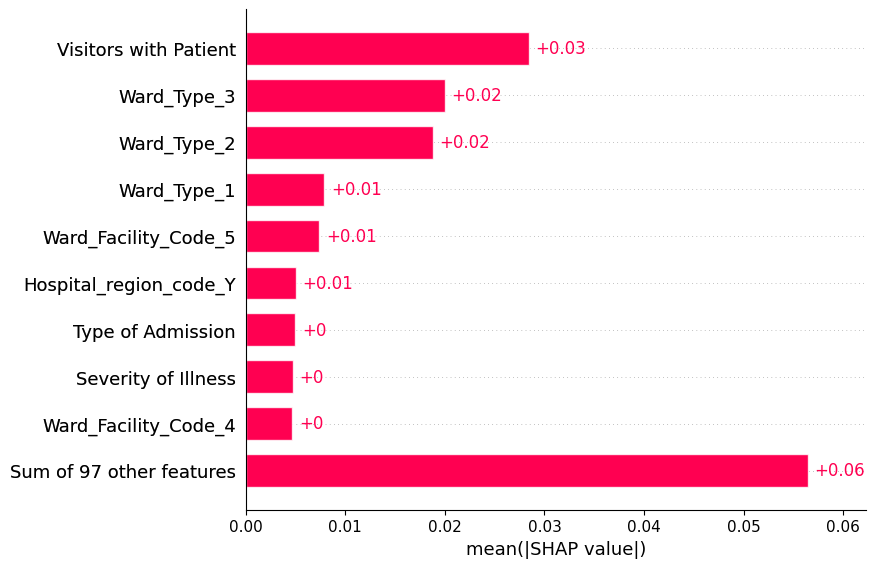


🔹 Class 8 SHAP Summary without SMOTE


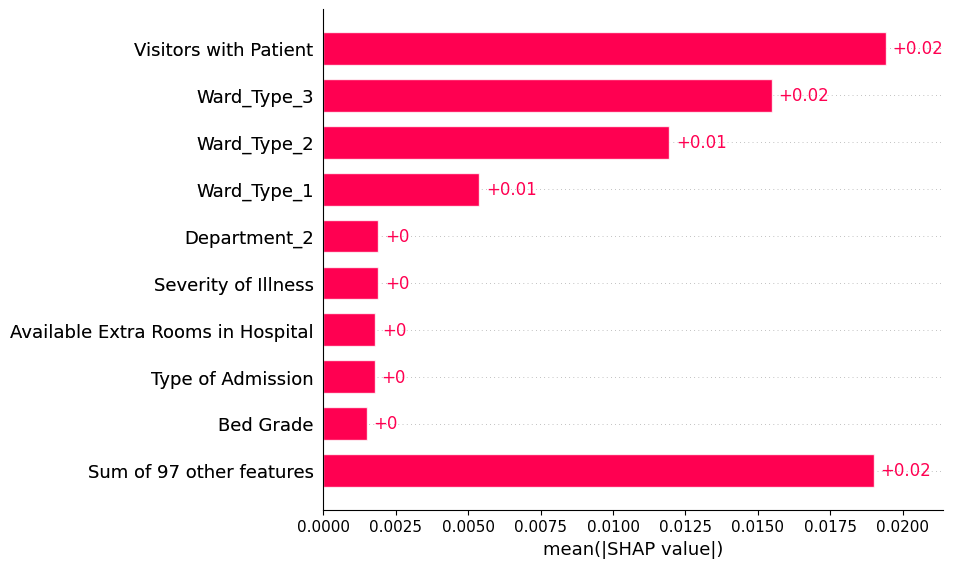


🔹 Class 9 SHAP Summary without SMOTE


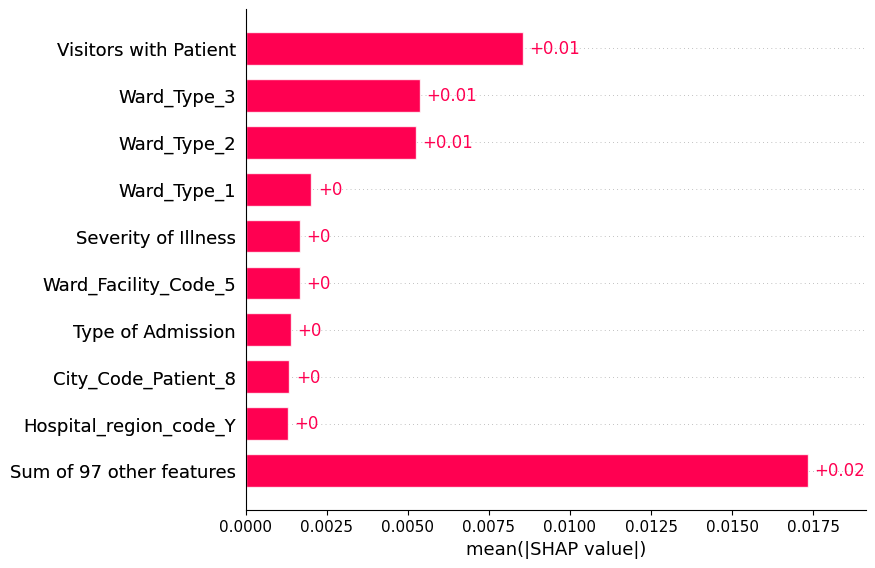


🔹 Class 10 SHAP Summary without SMOTE


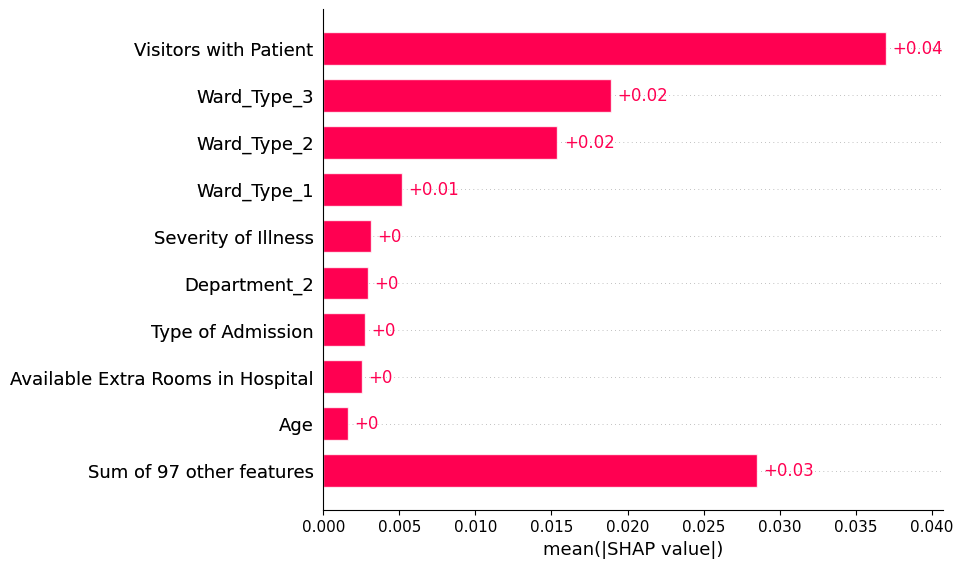

In [37]:
# SHAP Explainer for original model
explainer_orig = shap.Explainer(model_orig.predict, X_train)
shap_values_orig = explainer_orig(sample_X)

print("SHAP values shape (Original):", shap_values_orig.shape)

for i in range(shap_values_orig.shape[2]):
    print(f"\n🔹 Class {i} SHAP Summary without SMOTE")
    shap.plots.bar(shap_values_orig[:, :, i])



🔹 Class 0 SHAP Summary with SMOTE

🔹 Class 1 SHAP Summary with SMOTE

🔹 Class 2 SHAP Summary with SMOTE

🔹 Class 3 SHAP Summary with SMOTE

🔹 Class 4 SHAP Summary with SMOTE

🔹 Class 5 SHAP Summary with SMOTE

🔹 Class 6 SHAP Summary with SMOTE

🔹 Class 7 SHAP Summary with SMOTE

🔹 Class 8 SHAP Summary with SMOTE

🔹 Class 9 SHAP Summary with SMOTE

🔹 Class 10 SHAP Summary with SMOTE


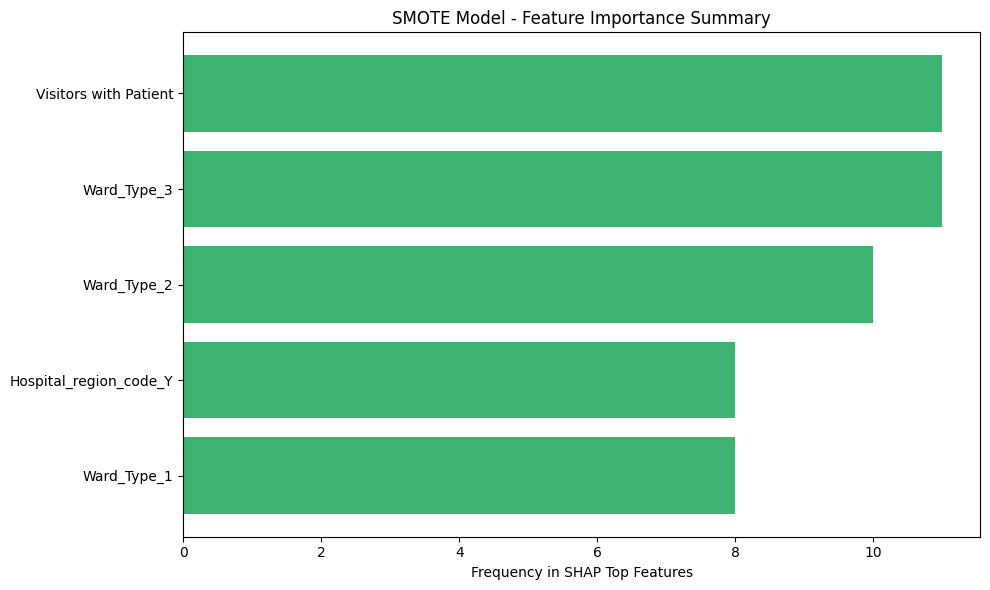

In [42]:
# Store top features per class in a list of lists
smote_shap_top_features = []

for i in range(shap_values_smote.shape[2]):  # Loop over classes
    print(f"\n🔹 Class {i} SHAP Summary with SMOTE")
    
    # Get mean absolute SHAP values for each feature
    mean_abs_shap = np.abs(shap_values_smote[:, :, i].values).mean(axis=0)
    
    # Get indices of top N features (e.g., 10)
    top_indices = np.argsort(mean_abs_shap)[-10:][::-1]
    
    # Map indices to feature names
    top_features = [sample_X.columns[idx] for idx in top_indices]
    smote_shap_top_features.append(top_features)


# Flatten the list of lists
flat_smote = [feature for sublist in smote_shap_top_features for feature in sublist]

# Count occurrences of each feature across all classes
smote_feature_counts = Counter(flat_smote)

# Create bar chart of feature frequencies
top_5_features = smote_feature_counts.most_common(5)
features_smote, counts_smote = zip(*top_5_features)

plt.figure(figsize=(10, 6))
plt.barh(features_smote, counts_smote, color='mediumseagreen')
plt.xlabel("Frequency in SHAP Top Features")
plt.title("SMOTE Model - Feature Importance Summary")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
